<a href="https://colab.research.google.com/github/santoshsahini19/ai-playground/blob/main/factor_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Implementing Exploratory Factor Analysis on Diabetes Health Indicators Dataset**

In [33]:
# install required libraries
!pip install factor_analyzer matplotlib torch seaborn


In [78]:
# import required libraries
import pandas as pd
import numpy as np
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import os
from google.colab import userdata

import warnings
# Ignore all FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)

Load the dataset:
- The Behavioral Risk Factor Surveillance System (BRFSS) is a health-related telephone survey that is collected annually by the CDC.
- It is a refined dataset containing 253,680 survey responses to the CDC's BRFSS2015
- Link to the data: [Kaggle Dataset](https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset?select=diabetes_012_health_indicators_BRFSS2015.csv)

In [79]:
# loaded data from github repository; need to add github token for loading raw csv file
diabetes_brfss_df = pd.read_csv("https://raw.githubusercontent.com/santoshsahini19/ai-playground/refs/heads/main/diabetes_012_health_indicators_BRFSS2015.csv?token={github_token}")
diabetes_brfss_df.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [81]:
diabetes_brfss_df = diabetes_brfss_df.drop(columns=["Diabetes_012"])

In [82]:
print("Shape of the data:", diabetes_brfss_df.shape)

Shape of the data: (253680, 21)


In [83]:
print("The features in the data:")
diabetes_brfss_df.columns

The features in the data:


Index(['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

In [84]:
# Standardize the data (mean=0, std=1) as FA assumes standardized variables
scaler = StandardScaler()
data_scaled = scaler.fit_transform(diabetes_brfss_df)

print(f"Dataset: {data_scaled}")

Dataset: [[ 1.15368814  1.16525449  0.19692156 ...  0.31690008 -1.06559465
  -1.4744874 ]
 [-0.86678537 -0.85818163 -5.07816412 ... -0.33793279  0.96327159
  -2.44013754]
 [ 1.15368814  1.16525449  0.19692156 ...  0.31690008 -1.06559465
   0.93963796]
 ...
 [-0.86678537 -0.85818163  0.19692156 ... -1.97501498 -0.05116153
  -1.95731247]
 [ 1.15368814 -0.85818163  0.19692156 ... -0.33793279 -0.05116153
  -2.44013754]
 [ 1.15368814  1.16525449  0.19692156 ...  0.31690008  0.96327159
  -1.95731247]]


In [85]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [86]:
def plot_heatmap(loadings, title):
    ''' Plot the heatmap for the loadings'''
    plt.figure(figsize=(12, 10))
    sns.heatmap(loadings, annot=False, cmap='coolwarm', center=0)
    plt.title(title)
    plt.show()

In [87]:
# prepare data
input_dim = data_scaled.shape[1]
latent_dim = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [88]:
dataset = TensorDataset(torch.tensor(data_scaled, dtype=torch.float32))
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

# autoencoder model
model = Autoencoder(input_dim, latent_dim).to(device)

# loss and optimizer initialization
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [89]:
# Train for 50 epochs
epochs = 50
for epoch in range(epochs):
    for data in dataloader:
        inputs = data[0].to(device)
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [10/50], Loss: 0.1838
Epoch [20/50], Loss: 0.1645
Epoch [30/50], Loss: 0.1684
Epoch [40/50], Loss: 0.1560
Epoch [50/50], Loss: 0.1247


In [90]:
# Extract latents
with torch.no_grad():
    latents = model.encoder(torch.tensor(data_scaled, dtype=torch.float32).to(device)).cpu().numpy()

In [91]:
print(f"Latent shape: {latents.shape}")

Latent shape: (253680, 5)


In [92]:
# FA on latents (unrotated)
fa_latent_unrot = FactorAnalyzer(n_factors=2, rotation=None, method='principal')  # e.g., 3 factors for latents
fa_latent_unrot.fit(latents)
loadings_latent_unrot = pd.DataFrame(fa_latent_unrot.loadings_, columns=[f'Factor {i+1}' for i in range(2)])

print("Latent Unrotated Loadings:\n", loadings_latent_unrot)

Latent Unrotated Loadings:
    Factor 1  Factor 2
0  0.404940  0.703545
1 -0.527667  0.317846
2  0.624058  0.630308
3  0.695997 -0.545387
4 -0.700301  0.186953


Unrotated loadings:
- Factor 1 loads strongly on variables 3 (+0.70), 2 (+0.62), and 4 (–0.70), with a moderate negative loading on 1 (–0.53). This suggests Factor 1 represents a contrast between variables 2–3 (positive) and variable 4–1 (negative).
- Factor 2 loads highly on 0 (+0.70) and 2 (+0.63), with moderate positive influence from 1 (+0.32) and negative from 3 (–0.55). Factor 2 seems to emphasize variable 0 and 2, opposed to 3.

In [93]:
# Varimax on latents
fa_latent_var = FactorAnalyzer(n_factors=2, rotation='varimax', method='principal')
fa_latent_var.fit(latents)
loadings_latent_var = pd.DataFrame(fa_latent_var.loadings_, columns=[f'Factor {i+1}' for i in range(2)])

print("Latent Varimax Loadings:\n", loadings_latent_var)

Latent Varimax Loadings:
    Factor 1  Factor 2
0  0.047841  0.810348
1  0.615532 -0.024066
2 -0.175506  0.869444
3 -0.881152 -0.073687
4  0.687949 -0.228250


Varimax loadings:
- Factor 1 loads strongly on variables 3 (–0.88) and 4 (+0.69), with moderate support from 1 (+0.62). This suggests Factor 1 reflects a contrast between variable 3 (negative) and variables 1, 4 (positive).
- Factor 2 loads strongly on variables 0 (+0.81) and 2 (+0.87), defining a clear grouping of those two variables.

In [94]:
# Promax on latents
fa_latent_pro = FactorAnalyzer(n_factors=2, rotation='promax', method='principal')
fa_latent_pro.fit(latents)
loadings_latent_pro = pd.DataFrame(fa_latent_pro.loadings_, columns=[f'Factor {i+1}' for i in range(2)])

print("Latent Promax Loadings:\n", loadings_latent_pro)

Latent Promax Loadings:
    Factor 1  Factor 2
0  0.113425  0.822456
1  0.619943  0.028060
2 -0.107477  0.863138
3 -0.896154 -0.149380
4  0.676706 -0.171989


Promax loadings:
- Factor 1 loads strongly on 3 (–0.90) and 4 (+0.68), with 1 (+0.62) also important. Similar interpretation to varimax, but Factor 1 and 2 are now allowed to correlate.
- Factor 2 loads strongly on 0 (+0.82) and 2 (+0.86).

In [99]:
fa_latent_var.loadings_

array([[ 0.04784069,  0.81034793],
       [ 0.61553155, -0.02406591],
       [-0.17550605,  0.86944425],
       [-0.88115195, -0.0736874 ],
       [ 0.68794914, -0.22825048]])

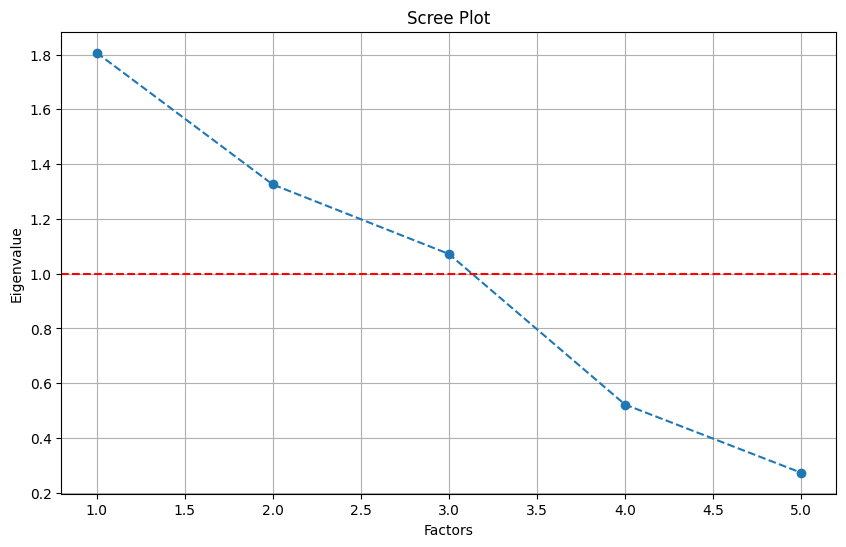

Eigenvalues: [1.80687292 1.32581337 1.07207208 0.52230071 0.27343226]
Suggested number of factors (Kaiser's criterion): 3


In [95]:
# Get eigenvalues
ev, v = fa_latent_var.get_eigenvalues()

# Scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(ev)+1), ev, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.axhline(y=1, color='r', linestyle='--')  # Kaiser's criterion
plt.grid(True)
plt.show()

# Interpretation
print("Eigenvalues:", ev[:10])  # Show first 10
num_factors = sum(ev > 1)  # e.g., 5 for Big Five
print(f"Suggested number of factors (Kaiser's criterion): {num_factors}")

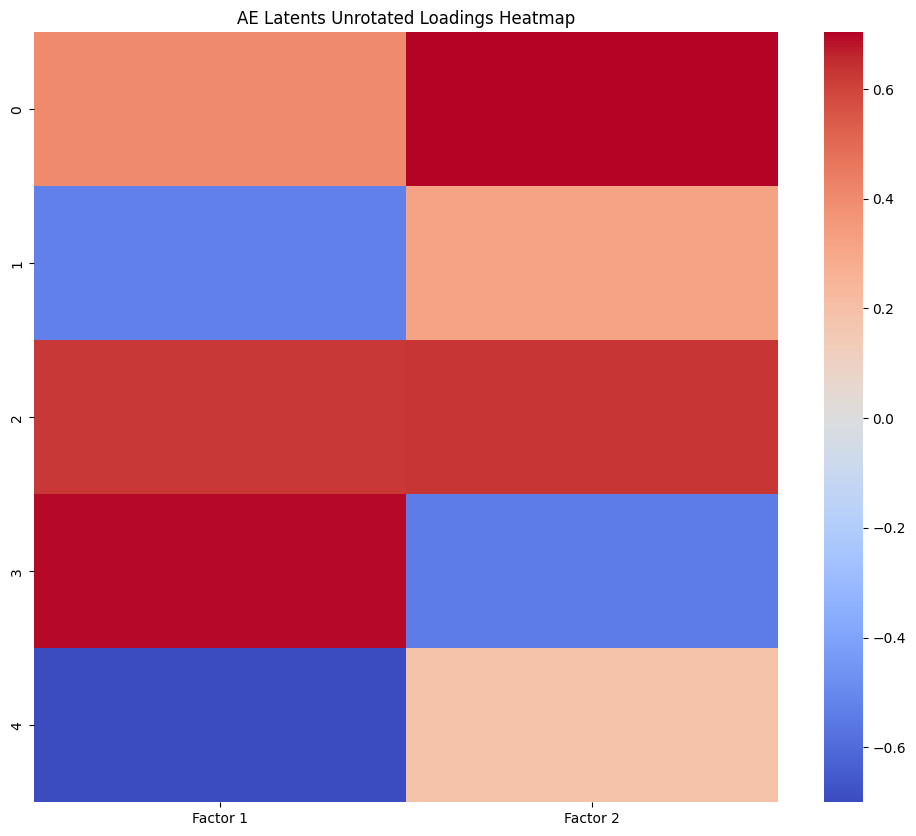

In [96]:
# Heatmaps for latents
plot_heatmap(loadings_latent_unrot, 'AE Latents Unrotated Loadings Heatmap')

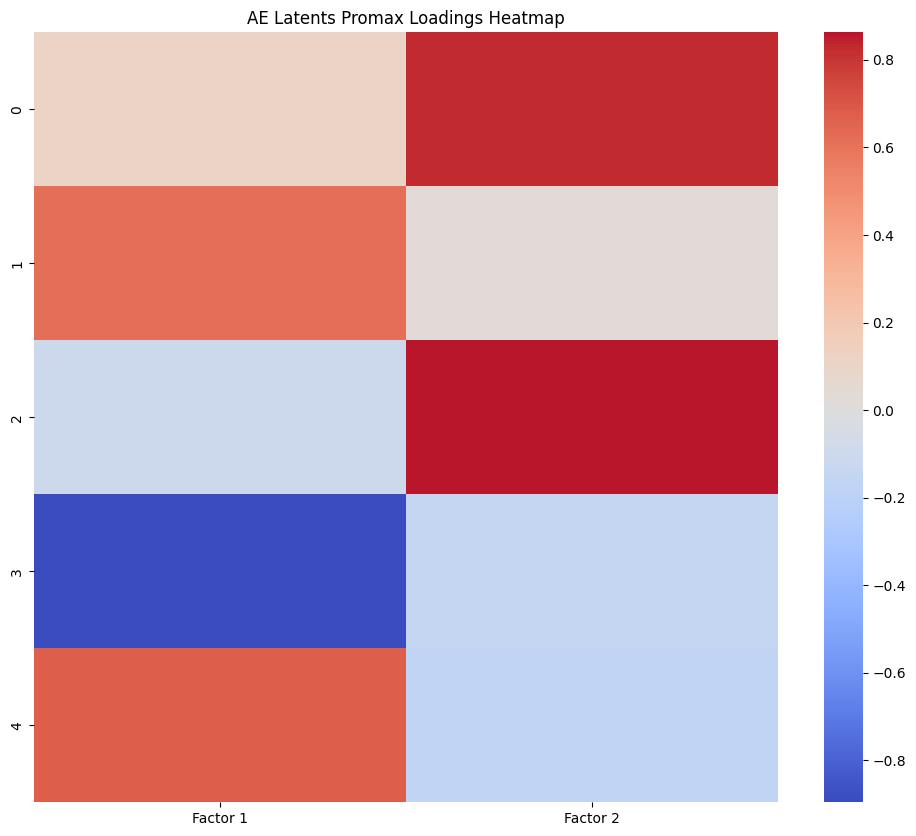

In [97]:
plot_heatmap(loadings_latent_pro, 'AE Latents Promax Loadings Heatmap')

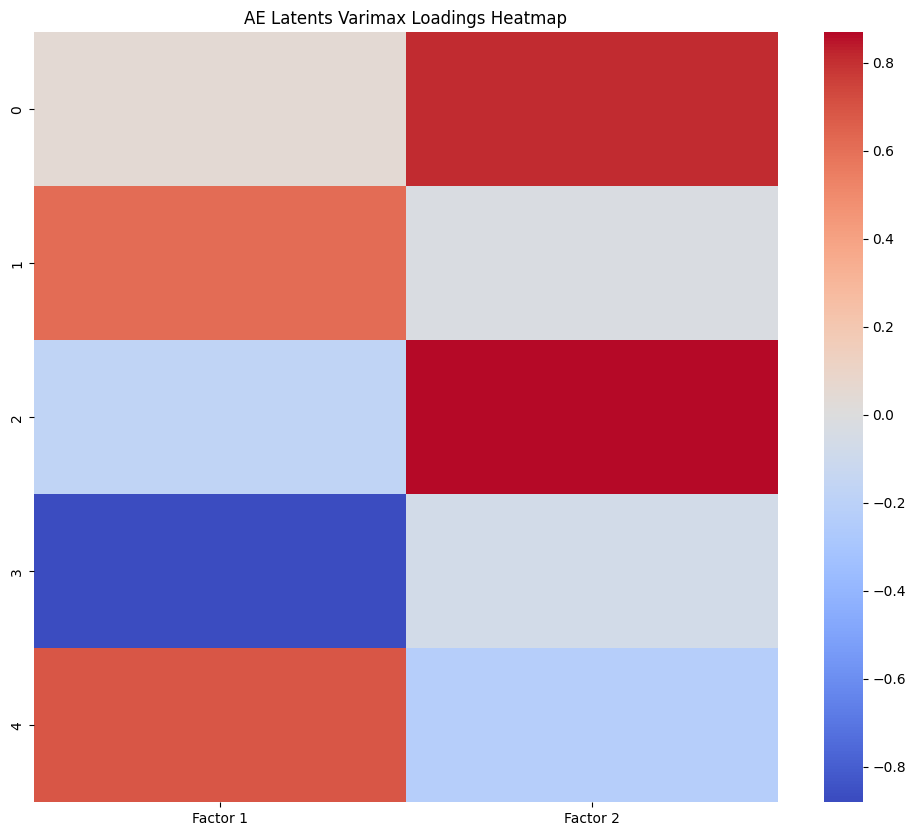

In [98]:
plot_heatmap(loadings_latent_var, 'AE Latents Varimax Loadings Heatmap')